# Environment Setup and Function Definitions

Before diving into our analysis, it's crucial to establish a solid foundation by setting up our analytical environment. This initial step involves configuring the necessary libraries and tools that will empower our data processing and visualization tasks. Following the environment setup, we will proceed to define a series of functions tailored to our specific analytical needs. These functions are designed to streamline the data manipulation, analysis, and visualization processes, ensuring a smooth and efficient workflow throughout our project. By carefully preparing our environment and crafting these essential functions, we lay the groundwork for a comprehensive and insightful analysis.



In [2]:
# set up the environment 
# Read the content of the setup script
setup_script = 'Setup/step2.py'

with open(setup_script, 'r') as file:
    setup_code = file.read()

# Execute the setup script
exec(setup_code)

The data has been preprocessed to ensure it is in a format compatible with the defined functions.

In [2]:


# Open the JSON file
with open('ProcessedData/sampled_year_2010_records.json', 'r', encoding='utf-8') as json_file:
    # Initialize lists to store data
    year_data = []
    n_citation_data = []
    abstract_data = []

    # Iterate through each line in the JSON file
    for line in json_file:
        try:
            # Parse each line as a JSON object
            record = json.loads(line)
            
            # Extract the desired fields
            year = record.get('Year', '')
            n_citation = record.get('n_citation', '')
            abstract = record.get('Abstract', '')

            # Append the data to the respective lists
            year_data.append(year)
            n_citation_data.append(n_citation)
            abstract_data.append(abstract)
        except json.JSONDecodeError:
            # Handle invalid JSON lines (if any)
            print(f"Skipping invalid JSON line: {line}")

# Define file names for CSV files
year_csv_file = 'ProcessedData/year_data.csv'
n_citation_csv_file = 'ProcessedData/n_citation_data.csv'
abstract_csv_file = 'ProcessedData/abstract_data.csv'

# Write data to CSV files
with open(year_csv_file, 'w', newline='', encoding='utf-8') as year_csv:
    year_writer = csv.writer(year_csv)
    year_writer.writerow(['Year'])
    year_writer.writerows(zip(year_data))

with open(n_citation_csv_file, 'w', newline='', encoding='utf-8') as n_citation_csv:
    n_citation_writer = csv.writer(n_citation_csv)
    n_citation_writer.writerow(['n_citation'])
    n_citation_writer.writerows(zip(n_citation_data))

with open(abstract_csv_file, 'w', newline='', encoding='utf-8') as abstract_csv:
    abstract_writer = csv.writer(abstract_csv)
    abstract_writer.writerow(['Abstract'])
    abstract_writer.writerows(zip(abstract_data))

print(f'Data saved to {year_csv_file}, {n_citation_csv_file}, and {abstract_csv_file}')


Data saved to ProcessedData/year_data.csv, ProcessedData/n_citation_data.csv, and ProcessedData/abstract_data.csv


In my previous thesis, I thoroughly explored the NLP process for topic modeling using Latent Dirichlet Allocation (LDA) and Non-Negative Matrix Factorization (NMF). I incorporated best practices identified in prior research to ensure robust and accurate results. The following steps were used:

1. **Loading Data**: Reads the dataset from a CSV file.
2. **Text Cleaning**: Removes punctuation and converts text to lowercase.
3. **Tokenization**: Splits text into individual words.
4. **Lemmatization**: Reduces words to their base form.
5. **Stopwords Removal**: Removes common stopwords.
6. **Dictionary Creation**: Creates a dictionary mapping words to unique IDs.
7. **Corpus Creation**: Converts text data into a bag-of-words format.

In [4]:


EN = pd.read_csv('ProcessedData/abstract_data.csv')
EN['text_processed'] = EN['Abstract'].map(lambda x: re.sub('[,\\.!?()]', '', x))
EN['text_processed'] = EN['text_processed'].map(lambda x: x.lower())
EN['text_word'] = EN['text_processed'].map(lambda x: re.sub('[,\\.!?()]', '', x).lower().split())
EN['word_lem'] = lemmatization(EN['text_word'], notags=True,language='EN')
final=remove_stopwords(EN['word_lem'],EN['word_lem'],language='EN',num_freq_stopwords=40,extrastopwords=[])
id2word = corpora.Dictionary(final)
corpus = [id2word.doc2bow(text) for text in final]

OSError: [E050] Can't find model 'en_core_web_lg'. It doesn't seem to be a Python package or a valid path to a data directory.

two models are created. a random state of 88 is set. 

In [169]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word, num_topics=20,random_state=88)
nmf_model = Nmf(corpus=corpus, id2word=id2word,num_topics=20,random_state=88)

The following shows one topic of the model

In [171]:
lda_model.show_topic(3, 100)

[('$', 0.012650117),
 ('design', 0.0081480825),
 ('high', 0.0058669853),
 ('at', 0.0054125832),
 ('/', 0.0052517373),
 ('video', 0.0045930813),
 ('processor', 0.004336765),
 ('performance', 0.004206914),
 ('set', 0.004092542),
 ('word', 0.004091234),
 ('power', 0.0040701176),
 ('bit', 0.0040569515),
 ('low', 0.00398156),
 ('%', 0.0038865437),
 ('core', 0.0038468565),
 ('frame', 0.0035691678),
 ('[', 0.0035237605),
 ('chip', 0.003515556),
 ("'s", 0.0034980061),
 ('tag', 0.0034150924),
 ('technology', 0.003368703),
 (']', 0.003316576),
 ('new', 0.0032472203),
 ('area', 0.0030642303),
 ('circuit', 0.0030231336),
 ('than', 0.0030075985),
 ('or', 0.0029939138),
 ('reduce', 0.0029867252),
 ('two', 0.002869711),
 ('technique', 0.0028580453),
 ('process', 0.0028576343),
 ('not', 0.0028088025),
 ('voltage', 0.0027747487),
 ('{', 0.0027469872),
 ('compare', 0.0027422502),
 ('code', 0.0027404896),
 ('improve', 0.0027186773),
 ('number', 0.0027183185),
 ('one', 0.0026845443),
 ('hardware', 0.00260

Calculate the topic distribution and save the file for further analysis. 

In [190]:
def topicdistribution(model, corpus, filename=None):
    topic_weights = []
    num_topics = model.num_topics
    for i, row_list in enumerate(model[corpus]):
        tw = [0] * num_topics
        for j, p in row_list:
            tw[j] = p
        topic_weights.append(tw)
    
    arr = pd.DataFrame(topic_weights).fillna(0).values
    tsne_model = TSNE(n_components=2, random_state=0, verbose=1,angle=0.99, init='pca')
    tsne = tsne_model.fit_transform(arr)

    toR = pd.DataFrame()
    toR['x_tsne'] = tsne[:, 0]
    toR['y_tsne'] = tsne[:, 1]
    toR['x_1_topic_probability'] = np.amax(arr, axis=1)
    toR['dominant_topic'] = np.argmax(arr, axis=1) 
    for t in range(num_topics):
        name = 'topic' + str(t)
        toR[name] = arr[:, t]

    if filename is not None:
        toR.to_csv(filename,index=False)

    return toR

topicdistribution(lda_model,corpus,filename='ProcessedData/lda.csv')
topicdistribution(nmf_model,corpus,filename='ProcessedData/nmf.csv')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8842 samples in 0.090s...
[t-SNE] Computed neighbors for 8842 samples in 2.081s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8842
[t-SNE] Computed conditional probabilities for sample 2000 / 8842
[t-SNE] Computed conditional probabilities for sample 3000 / 8842
[t-SNE] Computed conditional probabilities for sample 4000 / 8842
[t-SNE] Computed conditional probabilities for sample 5000 / 8842
[t-SNE] Computed conditional probabilities for sample 6000 / 8842
[t-SNE] Computed conditional probabilities for sample 7000 / 8842
[t-SNE] Computed conditional probabilities for sample 8000 / 8842
[t-SNE] Computed conditional probabilities for sample 8842 / 8842
[t-SNE] Mean sigma: 0.104219
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.079468
[t-SNE] KL divergence after 1000 iterations: 1.799854
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8842 samples in 0.176s...
[t-SNE] Computed nei

,x_tsne,y_tsne,x_1_topic_probability,dominant_topic,topic0,topic1,topic2,topic3,topic4,topic5,...,topic10,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19
0,10.899817,0.235941,0.223606,14,0.000000,0.027287,0.111995,0.000000,0.029296,0.000000,...,0.000000,0.209042,0.026397,0.000000,0.223606,0.000000,0.083752,0.000000,0.212675,0.000000
1,1.917597,-34.202465,0.365529,1,0.000000,0.365529,0.022199,0.000000,0.027146,0.000000,...,0.000000,0.091455,0.098301,0.178530,0.000000,0.081802,0.000000,0.000000,0.000000,0.000000
2,-17.966597,28.455248,0.278213,12,0.000000,0.000000,0.000000,0.000000,0.022443,0.145220,...,0.000000,0.155467,0.278213,0.000000,0.000000,0.000000,0.050029,0.044624,0.073143,0.028432
3,8.078309,-5.449518,0.284709,13,0.000000,0.025788,0.000000,0.000000,0.229081,0.000000,...,0.000000,0.269595,0.022796,0.284709,0.000000,0.000000,0.000000,0.000000,0.164842,0.000000
4,17.961988,-28.040997,0.338989,15,0.000000,0.184325,0.033969,0.000000,0.000000,0.000000,...,0.054164,0.288021,0.000000,0.000000,0.071560,0.338989,0.000000,0.011613,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8837,19.564381,-13.751108,0.346873,11,0.000000,0.068183,0.147217,0.000000,0.032202,0.000000,...,0.099727,0.346873,0.000000,0.111571,0.071807,0.000000,0.020872,0.000000,0.101548,0.000000
8838,-25.308477,-14.688014,0.394732,5,0.207365,0.012272,0.000000,0.037203,0.091361,0.394732,...,0.037585,0.000000,0.000000,0.000000,0.016451,0.000000,0.080068,0.000000,0.026138,0.000000
8839,-16.670441,-1.347622,0.303492,13,0.000000,0.069080,0.000000,0.055649,0.090981,0.136059,...,0.000000,0.026010,0.000000,0.303492,0.000000,0.000000,0.000000,0.000000,0.020147,0.000000
8840,7.430433,-38.363281,0.482874,1,0.000000,0.482874,0.000000,0.119705,0.000000,0.264563,...,0.000000,0.000000,0.000000,0.037063,0.000000,0.077918,0.000000,0.017877,0.000000,0.000000


In [113]:
import pickle
with open("ProcessedData/corpus.pkl", "wb") as f:
    pickle.dump(corpus, f)
with open("ProcessedData/final.pkl", "wb") as f:
    pickle.dump(final, f)


from gensim import models

# Assuming you have an LDA model named 'lda_model'
lda_model.save("ProcessedData/ldamodel")  # Save the model
nmf_model.save("ProcessedData/nmfmodel")  # Save the model

In [37]:
from gensim import models

# Assuming you have an LDA model named 'lda_model'
lda_model.save("ldamodel")  # Save the model
nmf_model.save("nmfmodel")  # Save the model
# To load the model later
#loaded_lda_model = models.LdaModel.load("your_model_filename")  # Load the model

Save the necessary data for statistical analysis as a CSV file for subsequent analysis.

In [193]:

combinecsv('ProcessedData/n_citation_data.csv','ProcessedData/lda.csv','ProcessedData/lda_for_regression.csv')
combinecsv('ProcessedData/n_citation_data.csv','ProcessedData/nmf.csv','ProcessedData/nmf_for_regression.csv')

,n_citation,x_tsne,y_tsne,x_1_topic_probability,dominant_topic,topic0,topic1,topic2,topic3,topic4,...,topic10,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19
0,0,10.899817,0.235941,0.223606,14,0.000000,0.027287,0.111995,0.000000,0.029296,...,0.000000,0.209042,0.026397,0.000000,0.223606,0.000000,0.083752,0.000000,0.212675,0.000000
1,0,1.917597,-34.202465,0.365529,1,0.000000,0.365529,0.022199,0.000000,0.027146,...,0.000000,0.091455,0.098301,0.178530,0.000000,0.081802,0.000000,0.000000,0.000000,0.000000
2,10,-17.966597,28.455248,0.278213,12,0.000000,0.000000,0.000000,0.000000,0.022443,...,0.000000,0.155467,0.278213,0.000000,0.000000,0.000000,0.050029,0.044624,0.073143,0.028432
3,28,8.078309,-5.449518,0.284709,13,0.000000,0.025788,0.000000,0.000000,0.229081,...,0.000000,0.269595,0.022796,0.284709,0.000000,0.000000,0.000000,0.000000,0.164842,0.000000
4,3,17.961988,-28.040997,0.338989,15,0.000000,0.184325,0.033969,0.000000,0.000000,...,0.054164,0.288021,0.000000,0.000000,0.071560,0.338989,0.000000,0.011613,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8837,4,19.564380,-13.751108,0.346873,11,0.000000,0.068183,0.147217,0.000000,0.032202,...,0.099727,0.346873,0.000000,0.111571,0.071807,0.000000,0.020872,0.000000,0.101548,0.000000
8838,2,-25.308477,-14.688014,0.394732,5,0.207365,0.012272,0.000000,0.037203,0.091361,...,0.037585,0.000000,0.000000,0.000000,0.016451,0.000000,0.080068,0.000000,0.026138,0.000000
8839,1,-16.670440,-1.347622,0.303492,13,0.000000,0.069080,0.000000,0.055649,0.090981,...,0.000000,0.026010,0.000000,0.303492,0.000000,0.000000,0.000000,0.000000,0.020147,0.000000
8840,7,7.430433,-38.363280,0.482874,1,0.000000,0.482874,0.000000,0.119705,0.000000,...,0.000000,0.000000,0.000000,0.037063,0.000000,0.077918,0.000000,0.017877,0.000000,0.000000


Tokens are the input for topic modelling. To have a better view of the input data. Descriptive statistics for both term frequency and document frequency is presented below. 

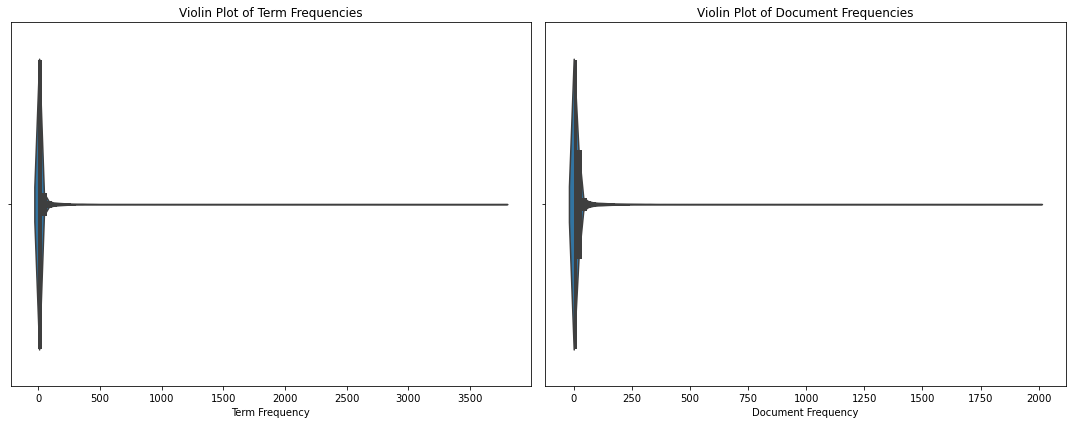

In [6]:
import pickle

with open("ProcessedData/corpus.pkl", "rb") as f:
    corpus = pickle.load(f)

# Load the final object
with open("ProcessedData/final.pkl", "rb") as f:
    final = pickle.load(f)

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your data structure is a list of lists
data = final
# Flatten the list of lists into a single list for term frequency
all_values = [item for sublist in data for item in sublist]

# Calculate the frequency of each unique value (Term Frequency)
term_frequency_counts = Counter(all_values)

# Calculate the document frequency
doc_frequency_counts = Counter()
for sublist in data:
    unique_items = set(sublist)
    for item in unique_items:
        doc_frequency_counts[item] += 1

# Convert the frequency counts to DataFrames for plotting
term_frequency_df = pd.DataFrame(list(term_frequency_counts.items()), columns=['Term', 'Term Frequency'])
doc_frequency_df = pd.DataFrame(list(doc_frequency_counts.items()), columns=['Term', 'Document Frequency'])



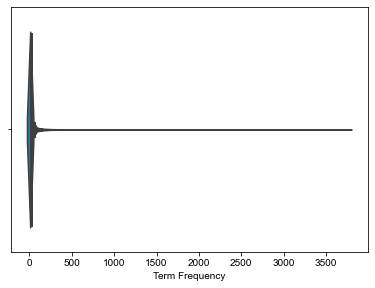

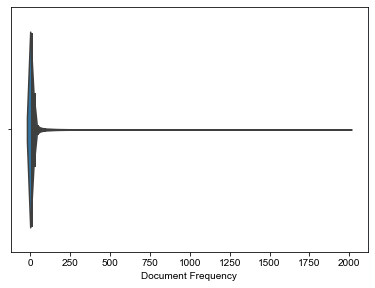

In [13]:
from matplotlib import rcParams
# Set the font to Arial for APA style
rcParams['font.family'] = 'Arial'

# Create the Term Frequency violin plot
plt.figure(figsize=(6.4, 4.5))
sns.violinplot(x='Term Frequency', data=term_frequency_df, inner='stick')

plt.xlabel('Term Frequency')
plt.savefig('Graphs/term_frequency_violin_plot.png', dpi=300)
plt.show()

# Create the Document Frequency violin plot
plt.figure(figsize=(6.4, 4.5))
sns.violinplot(x='Document Frequency', data=doc_frequency_df, inner='stick')

plt.xlabel('Document Frequency')
plt.savefig('Graphs/document_frequency_violin_plot.png', dpi=300)
plt.show()

In [7]:
term_frequency_df.describe()

,Term Frequency
count,31334.000000
mean,24.827504
std,124.002883
min,1.000000
25%,1.000000
50%,2.000000
75%,6.000000
max,3770.000000


In [8]:
doc_frequency_df.describe()

,Document Frequency
count,31334.000000
mean,18.061307
std,89.104374
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,1992.000000


In [18]:
doc_frequency_df[doc_frequency_df['Document Frequency']>1500]

,Term,Document Frequency
36,well,1866
80,application,1574
85,provide,1882
96,at,1976
129,study,1915
133,different,1514
134,network,1522
147,or,1992
228,information,1607
238,not,1973
